In [53]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
sns.set()
plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

In [54]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y %m %d %H')

In [55]:
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', 
                        parse_dates=[['year', 'month', 'day', 'hour']], 
                        index_col=0, 
                        date_parser=parse)
df.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [56]:
# 删除无用列
df.drop('No', axis=1, inplace=True) 

# 修改剩余列名称
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'

df['pollution'].fillna(0, inplace=True) # 将所有空值替换为0

# 删除前24小时行（因为有缺失）
df = df[24:]

# 将离散类别型特征数值化
encoder = preprocessing.LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


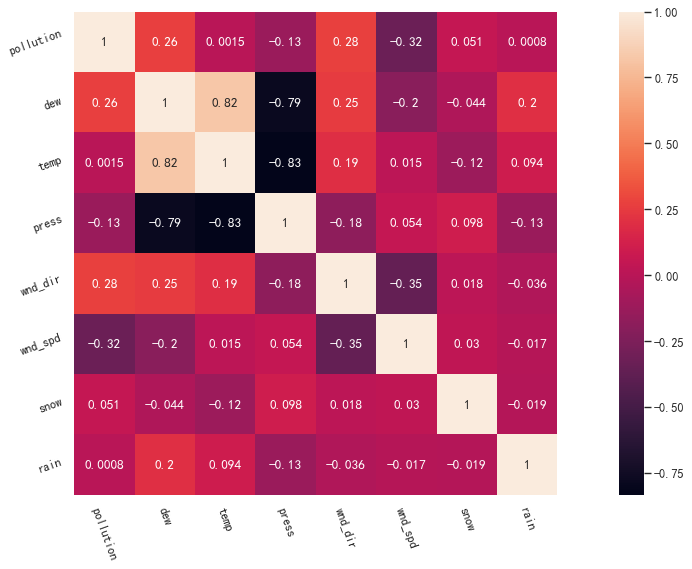

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8), dpi=80)
hitmapTemp = df[list(df.columns)]
hitmapData = hitmapTemp.corr(method='spearman') # method：可选值为{‘pearson’, ‘kendall’, ‘spearman’}
sns.heatmap(hitmapData, vmax=1, square=True, annot=True)
# plt.savefig('./figs/Correlation-Matrix.png')
plt.xticks(rotation=-70)
plt.yticks(rotation=20)
plt.show()

In [58]:
from sklearn.preprocessing import MinMaxScaler
# 确保所有数据是浮点数类型
values = df.values
values = values.astype('float32')  

# # 对特征标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# 分离出特征和标签
data = scaled
label = scaled[:, 0]

In [59]:
def generate_pair(x, ts):
    length = len(x)
    start, end = 0, length - ts
    data = []
    label = []
    for i in range(end):
        data.append(x[i: i+ts, :])
        label.append(x[i+ts, :])
    return np.array(data, dtype=np.float64), np.array(label, dtype=np.float64)

In [60]:
window_size = 72
data1, label1 = generate_pair(data, ts=window_size)

In [61]:
# 划分数据集
train_test_split = int(0.7 * len(label1))
train_X = data1[0: train_test_split]
train_y = label1[0: train_test_split]
test_X = data1[train_test_split:]
test_y = label1[train_test_split:]

In [62]:
print(len(df))
print(test_y.shape)

43800
(13119, 8)


In [63]:
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

dim = 8
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.6))
model.add(Dense(dim))
model.compile(loss='mae', optimizer='adam')

# 训练模型
history = model.fit(train_X, train_y, 
                    epochs=5, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=True)

# 开始预测
yhat = model.predict(test_X) 

Epoch 1/5
479/479 - 76s - loss: 0.0819 - val_loss: 0.0453 - 76s/epoch - 159ms/step
Epoch 2/5
479/479 - 66s - loss: 0.0547 - val_loss: 0.0405 - 66s/epoch - 137ms/step
Epoch 3/5
479/479 - 70s - loss: 0.0486 - val_loss: 0.0393 - 70s/epoch - 147ms/step
Epoch 4/5
479/479 - 65s - loss: 0.0455 - val_loss: 0.0387 - 65s/epoch - 137ms/step
Epoch 5/5
479/479 - 65s - loss: 0.0443 - val_loss: 0.0376 - 65s/epoch - 135ms/step
410/410 [==============================] - 15s 33ms/step


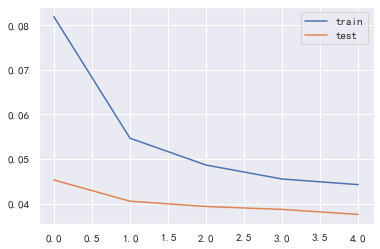

In [64]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

30559 30659


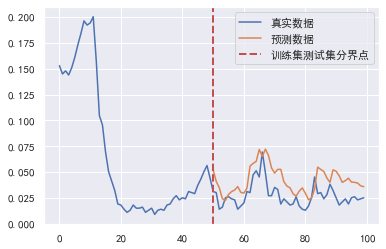

In [77]:
siz = 50
lb = train_test_split - siz
ub = train_test_split + siz
length = len(yhat[:siz])

print(lb, ub)

_x = range(2*siz)
_xx = range(siz, 2*siz)

plt.plot(_x, label1[lb: ub, 0])
plt.plot(_xx, yhat[:siz, 0])
plt.axvline(x=siz, c="r", ls="--", lw=2)

plt.legend(['真实数据', '预测数据', '训练集测试集分界点'])
plt.show()

In [96]:
target = 10
lst = []
for i in range(target):

    input_x = data[len(data)-window_size:len(data), :]
    input_x = np.expand_dims(input_x, axis=0)
    
    y_pred = model.predict(input_x)

    data = np.vstack((data, y_pred))
    lst.append(y_pred)

1/1 [==============================] - 0s 30ms/step


In [97]:
result = np.array(lst).squeeze(1)
result = scaler.inverse_transform(result)
result[:,0]

array([155.79645, 155.7982 , 155.79988, 155.80151, 155.8031 , 155.80461,
       155.80609, 155.80751, 155.80888, 155.81021], dtype=float32)

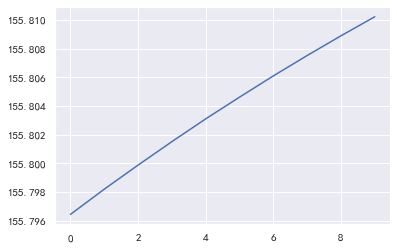

In [98]:
plt.plot(result[:,0])
plt.show()

In [103]:
34 or 12

34